# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [54]:
import warnings
import math
import re

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import spacy

from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

In [2]:
# Filter warnings

# Ignore MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [5]:
try:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('data/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
display(df_reviews.head())
df_reviews.info()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## Data Preprocessing

In [7]:
print(df_reviews['title_type'].value_counts())
print("\nWe know that our client is specifically concerned with movie reviews, so we will drop all other title types (we will keep 'movie' and 'tvMovie')\n")

# Drop all title types except 'movie' and 'tvMovie'
df_reviews = df_reviews[df_reviews['title_type'].isin(['movie', 'tvMovie'])]
print(df_reviews['title_type'].value_counts())

title_type
movie           36861
tvMovie          2892
video            2742
tvSeries         2246
short             887
tvMiniSeries      713
tvEpisode         635
tvSpecial         183
videoGame         154
tvShort            18
Name: count, dtype: int64

We know that our client is specifically concerned with movie reviews, so we will drop all other title types (we will keep 'movie' and 'tvMovie')

title_type
movie      36861
tvMovie     2892
Name: count, dtype: int64


In [8]:
# Let's confirm that each 'tconst' has only one 'primary_title' associated with it
assert df_reviews.groupby('tconst')['primary_title'].nunique().max() == 1
print('Each tconst has only one primary_title associated with it.')

# Assert there are no full duplicates
assert df_reviews.duplicated().sum() == 0
print('No full duplicates found.')

Each tconst has only one primary_title associated with it.
No full duplicates found.


Surprisingly, there does seem to be review duplicates. Let's check them out.

In [9]:
# Display douplicate reviews
display(df_reviews[df_reviews['review'].duplicated(keep=False)].sort_values(by='review').head())

# Count the number of duplicate reviews
print("Count of duplicate reviews:", df_reviews['review'].duplicated().sum())

# Count the number of rows that have duplicate reviews and tconst
print("Count of duplicate reviews and tconst:", df_reviews[['review', 'tconst']].duplicated().sum())

print("\n### Dropping duplicates ###\n")
# Drop reviews that are duplicates
df_reviews = df_reviews.drop_duplicates(subset='review')

# Assert there are no duplicates in the 'review' column
assert df_reviews['review'].duplicated().sum() == 0
print('No duplicates found in the "review" column')
# Assert there are no missing values in the 'review' column
assert df_reviews['review'].isna().sum() == 0
print('No missing values found in the "review" column')
# Assert there are no empty strings in the 'review' column
assert (df_reviews['review'] == '').sum() == 0
print('No empty strings found in the "review" column')

print("\n### POS Column - TARGET ###")
# Assert there are no missing values in the 'pos' column
assert df_reviews['pos'].isna().sum() == 0
print('No missing values found in the "pos" column')
# Assert 'pos' values are either 0 or 1
assert df_reviews['pos'].isin([0, 1]).all()
print('All "pos" values are either 0 or 1')

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
33040,tt0145503,movie,Sunshine,Sunshine,1999,\N,181,0,"Drama,History,Romance",7.5,12788,"Back in his youth, the old man had wanted to ...",2,neg,0,train,7286
33041,tt0145503,movie,Sunshine,Sunshine,1999,\N,181,0,"Drama,History,Romance",7.5,12788,"Back in his youth, the old man had wanted to ...",2,neg,0,train,7287
36174,tt0082252,movie,The Decline of Western Civilization,The Decline of Western Civilization,1981,\N,100,0,"Documentary,History,Music",7.6,3448,"First of all, I reviewed this documentary bec...",10,pos,1,test,11675
36175,tt0082252,movie,The Decline of Western Civilization,The Decline of Western Civilization,1981,\N,100,0,"Documentary,History,Music",7.6,3448,"First of all, I reviewed this documentary bec...",10,pos,1,test,11676
36803,tt0436295,movie,The Fall of Fujimori,The Fall of Fujimori,2005,\N,83,0,Documentary,7.4,279,A friend and I went to see this movie. We have...,1,neg,0,test,12346


Count of duplicate reviews: 71
Count of duplicate reviews and tconst: 71

### Dropping duplicates ###

No duplicates found in the "review" column
No missing values found in the "review" column
No empty strings found in the "review" column

### POS Column - TARGET ###
No missing values found in the "pos" column
All "pos" values are either 0 or 1


In [10]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39682 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           39682 non-null  object 
 1   title_type       39682 non-null  object 
 2   primary_title    39682 non-null  object 
 3   original_title   39682 non-null  object 
 4   start_year       39682 non-null  int64  
 5   end_year         39682 non-null  object 
 6   runtime_minutes  39682 non-null  object 
 7   is_adult         39682 non-null  int64  
 8   genres           39682 non-null  object 
 9   average_rating   39680 non-null  float64
 10  votes            39680 non-null  Int64  
 11  review           39682 non-null  object 
 12  rating           39682 non-null  int64  
 13  sp               39682 non-null  object 
 14  pos              39682 non-null  int64  
 15  ds_part          39682 non-null  object 
 16  idx              39682 non-null  int64  
dtypes: Int64(1), floa

Since our models are going to be trained exclusively on the text within the `review` column, we don't need to be concerned with checking any other aspects of the data.

## EDA

Let's check the number of movies and reviews over years.

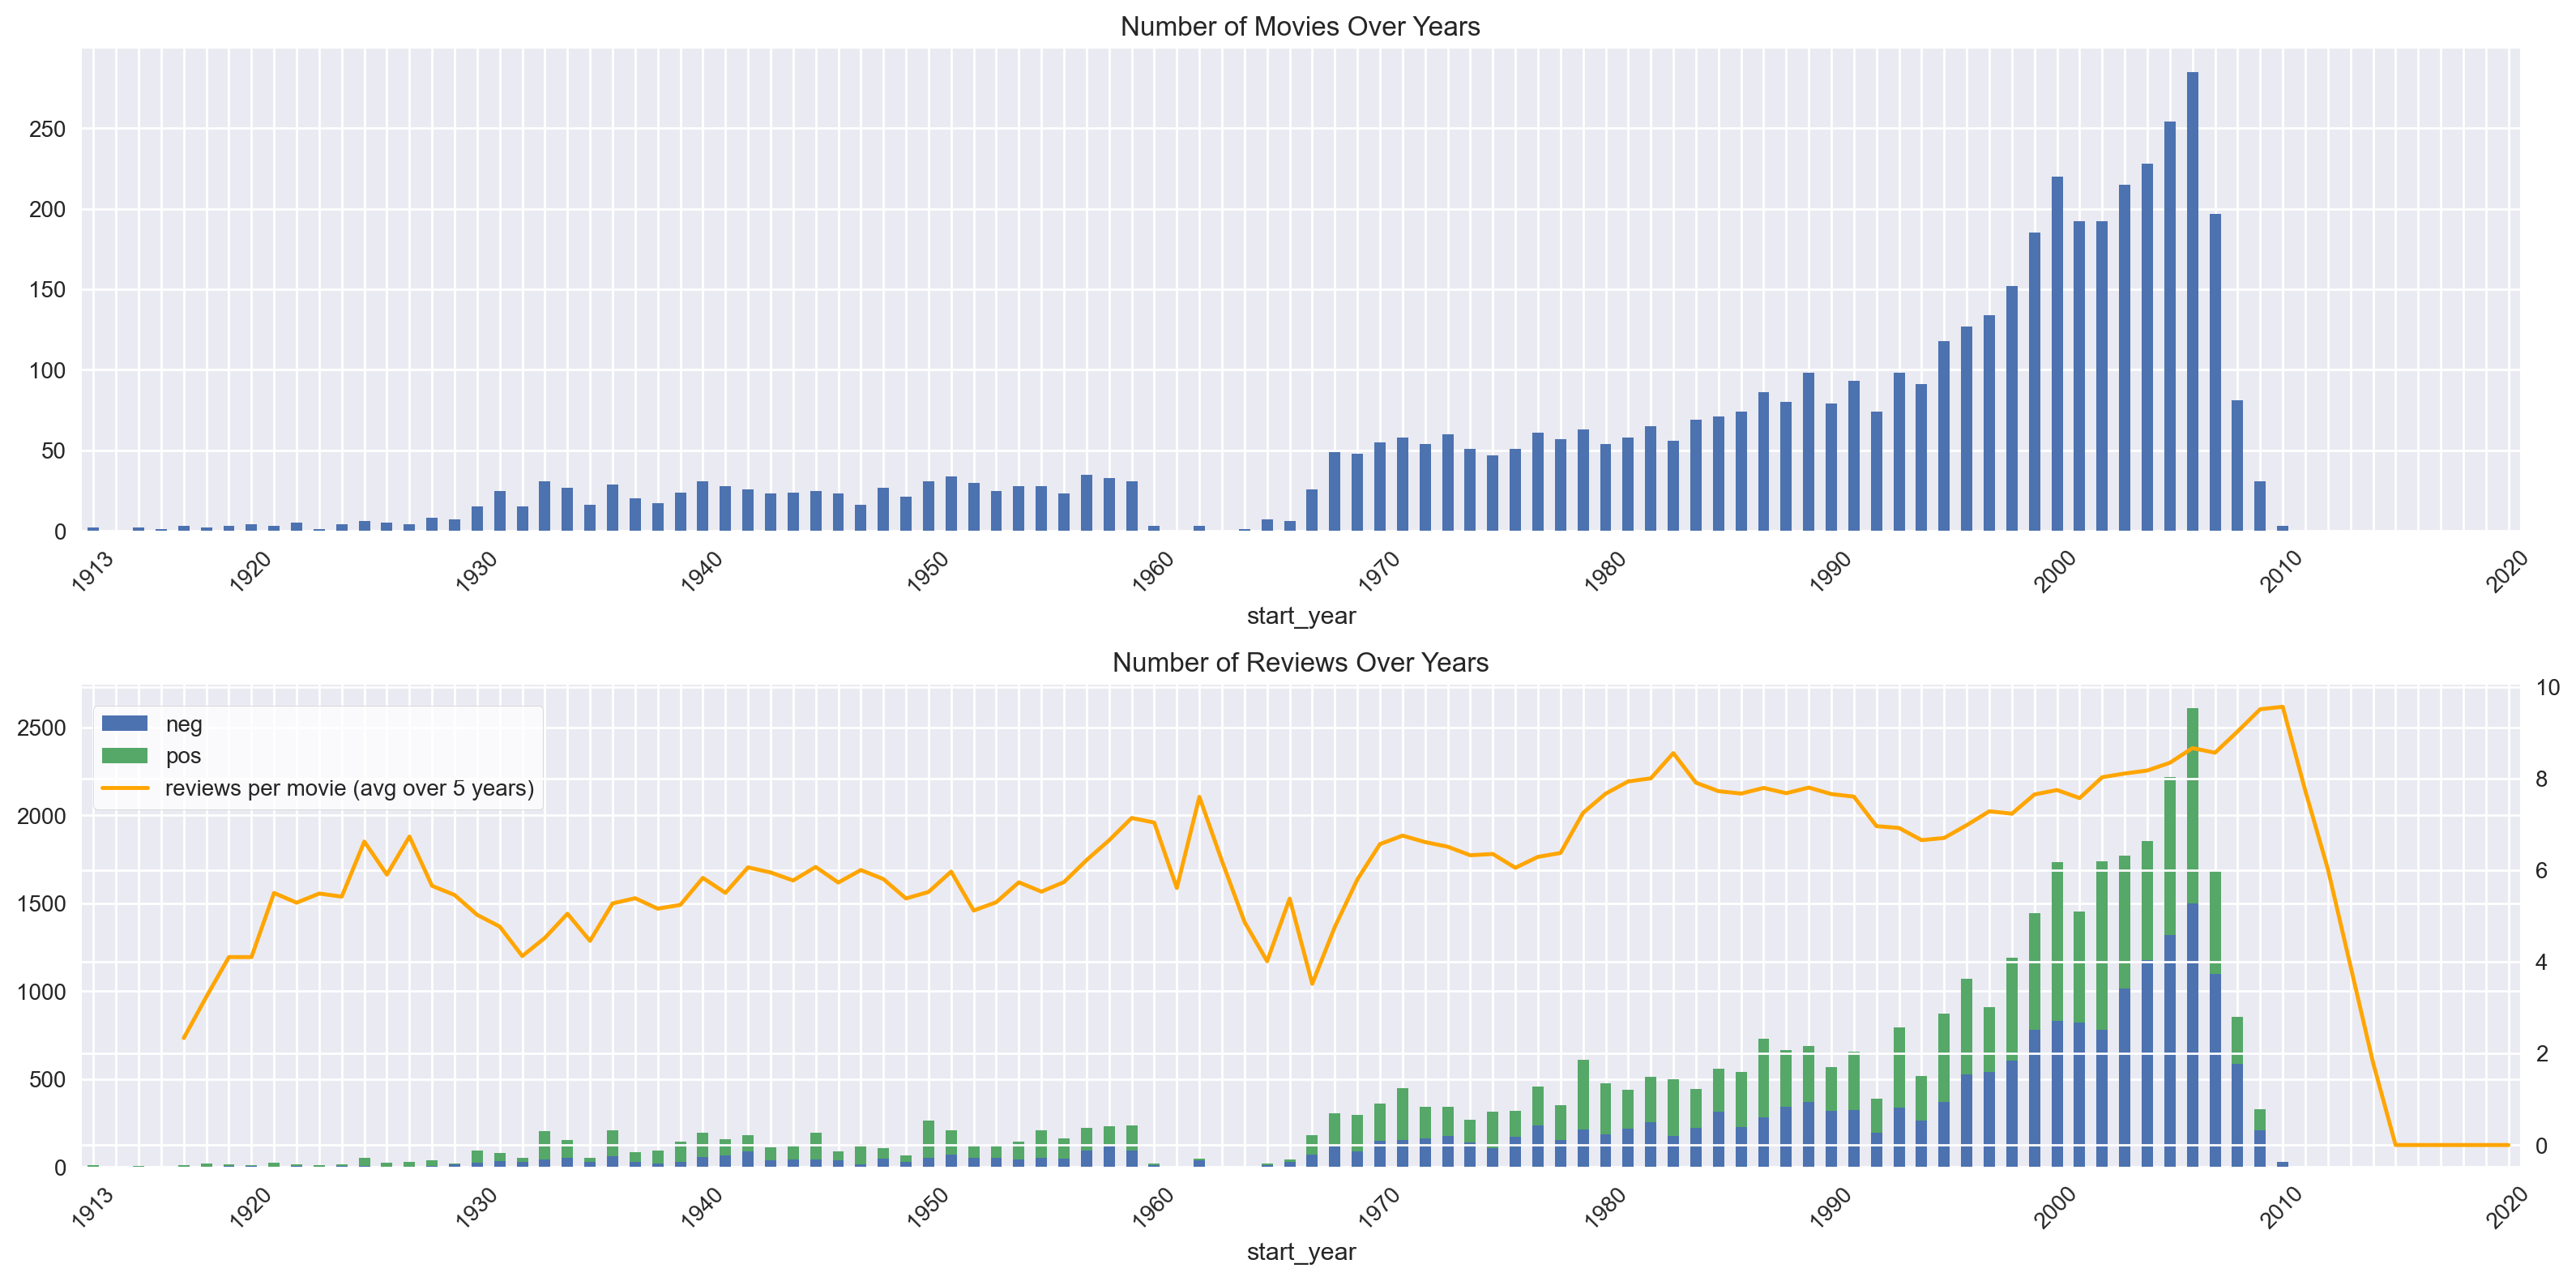

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Plotting number of movies over years
ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

# Highlight every ten years for visibility
start_year = dft1.index.min()
end_year = max(dft1.index.max(), 2021)
years = np.arange(start_year, end_year + 1, 10)

ax.set_xticks(np.arange(len(dft1.index)))
ax.set_xticklabels(dft1.index, rotation=45)

for label in ax.get_xticklabels():
    year = int(label.get_text())
    if year % 10 != 0 and year != start_year and year != end_year:
        label.set_visible(False)

# Plotting number of reviews over years
ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, ax=ax)

dft2_count = df_reviews['start_year'].value_counts().sort_index()
dft2_count = dft2_count.reindex(index=np.arange(dft2_count.index.min(), max(dft2_count.index.max(), 2021))).fillna(0)
dft3 = (dft2_count / dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

# Get handles and labels from both axes and combine them
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = axt.get_legend_handles_labels()
# Replace '0' with 'neg' and '1' with 'pos' in labels1
labels1 = ['neg' if label == '0' else 'pos' if label == '1' else label for label in labels1]

ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, facecolor='white', bbox_to_anchor=(0, 0.98))

ax.set_title('Number of Reviews Over Years')

# Highlight every ten years for visibility
start_year = dft2.index.min()
end_year = max(dft2.index.max(), 2021)
years = np.arange(start_year, end_year + 1, 10)

ax.set_xticks(np.arange(len(dft2.index)))
ax.set_xticklabels(dft2.index, rotation=45)

for label in ax.get_xticklabels():
    year = int(label.get_text())
    if year % 10 != 0 and year != start_year and year != end_year:
        label.set_visible(False)

fig.tight_layout()
plt.show()


As one would expect, there are more movies in recent years. Oddly, there is a dip movies between 1960 and 1967. The sharp decline around 2006 suggest that the data was probably collected sometime in 2010. On the second plot we can see that the distribution of positive to negative reviews is about 50/50 throughout, while the number of reviews per movie rises sharply for movies released around 1994.

Let's check the distribution of number of reviews per movie with the exact counting and KDE.

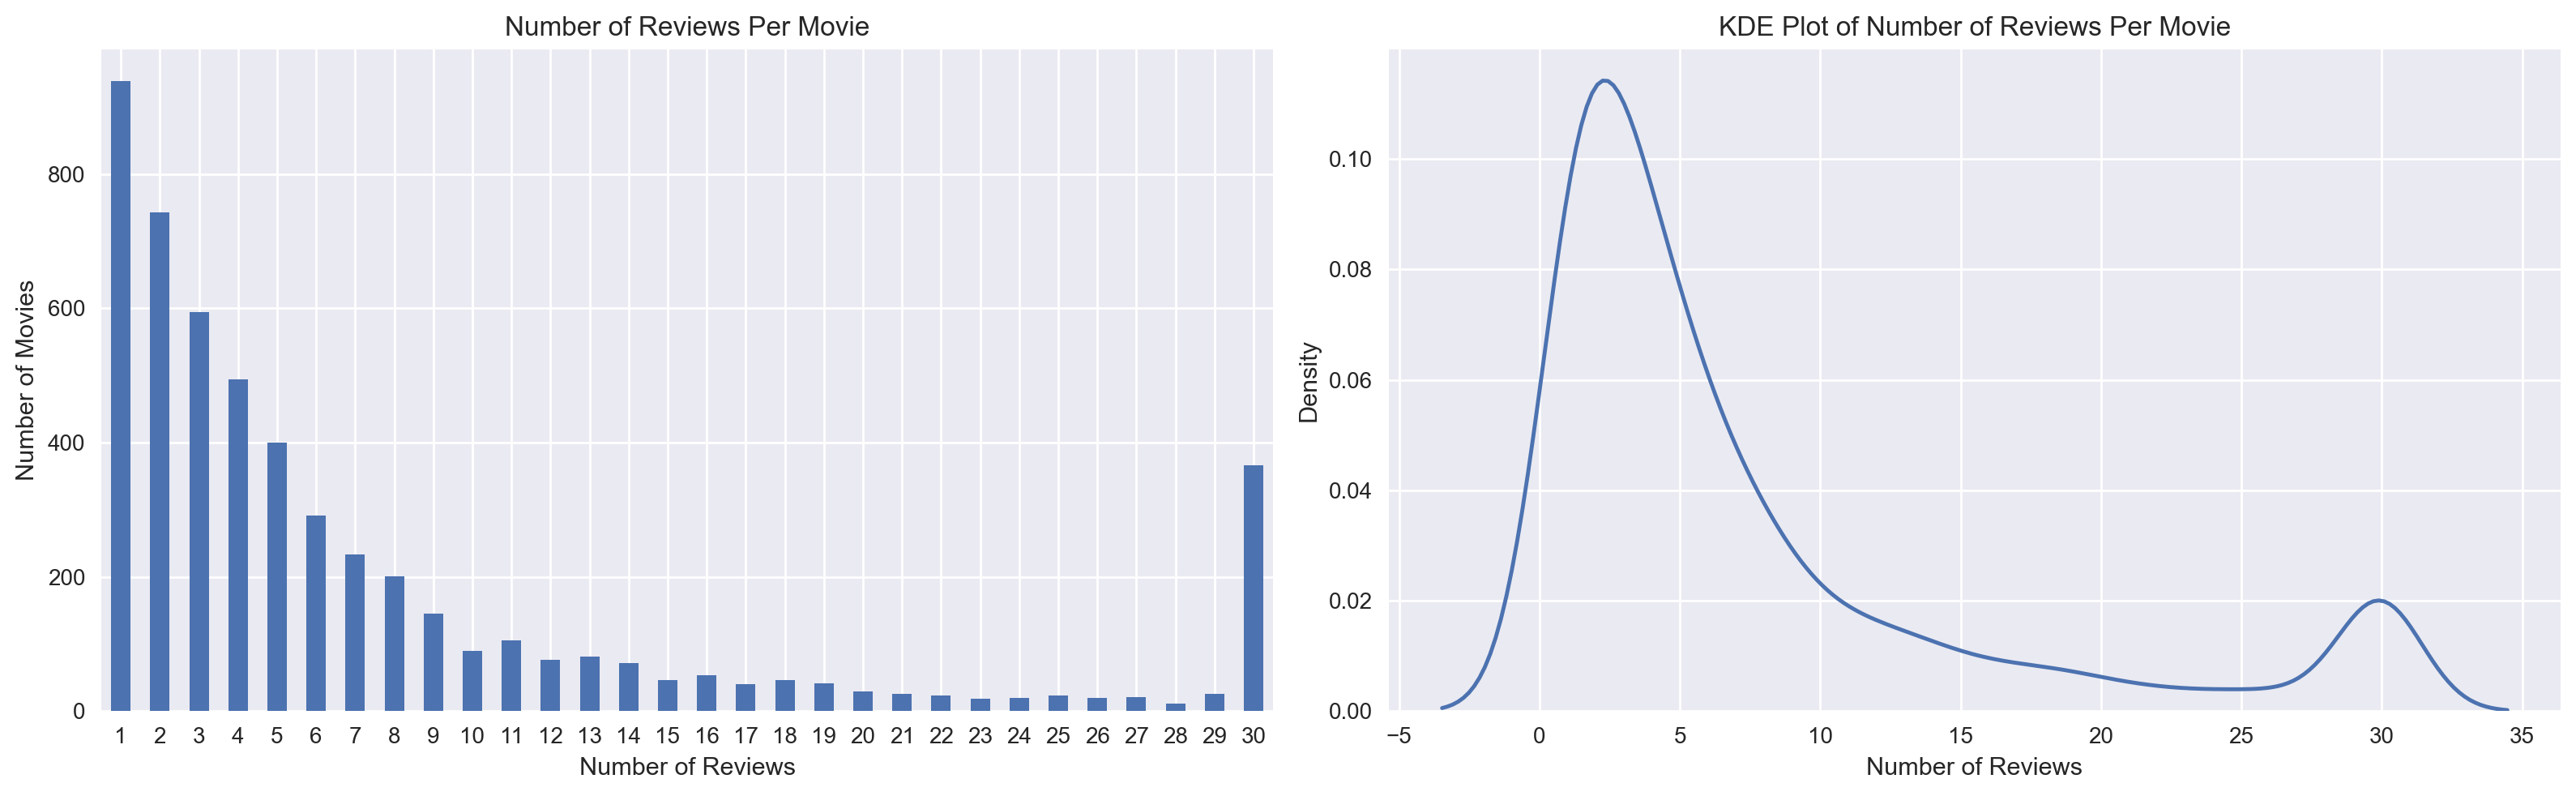

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Number of Reviews Per Movie')
ax.set_xlabel('Number of Reviews')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # Rotate the xticks for better visibility
ax.set_ylabel('Number of Movies')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of Number of Reviews Per Movie')
ax.set_xlabel('Number of Reviews')

fig.tight_layout()

Most movies have very few reviews. However, some movies have 30 or more reviews. This makes sense: "blockbuster" movies will get a lot of reviews, while most other movies will only be reviewed by a few people. Essentially, you can expect the number of reviews per movie to decline until the film reaches a certain tipping point of popularity where many people submit a review.  

Lets take a look at the ratings balance between the training and test sets.

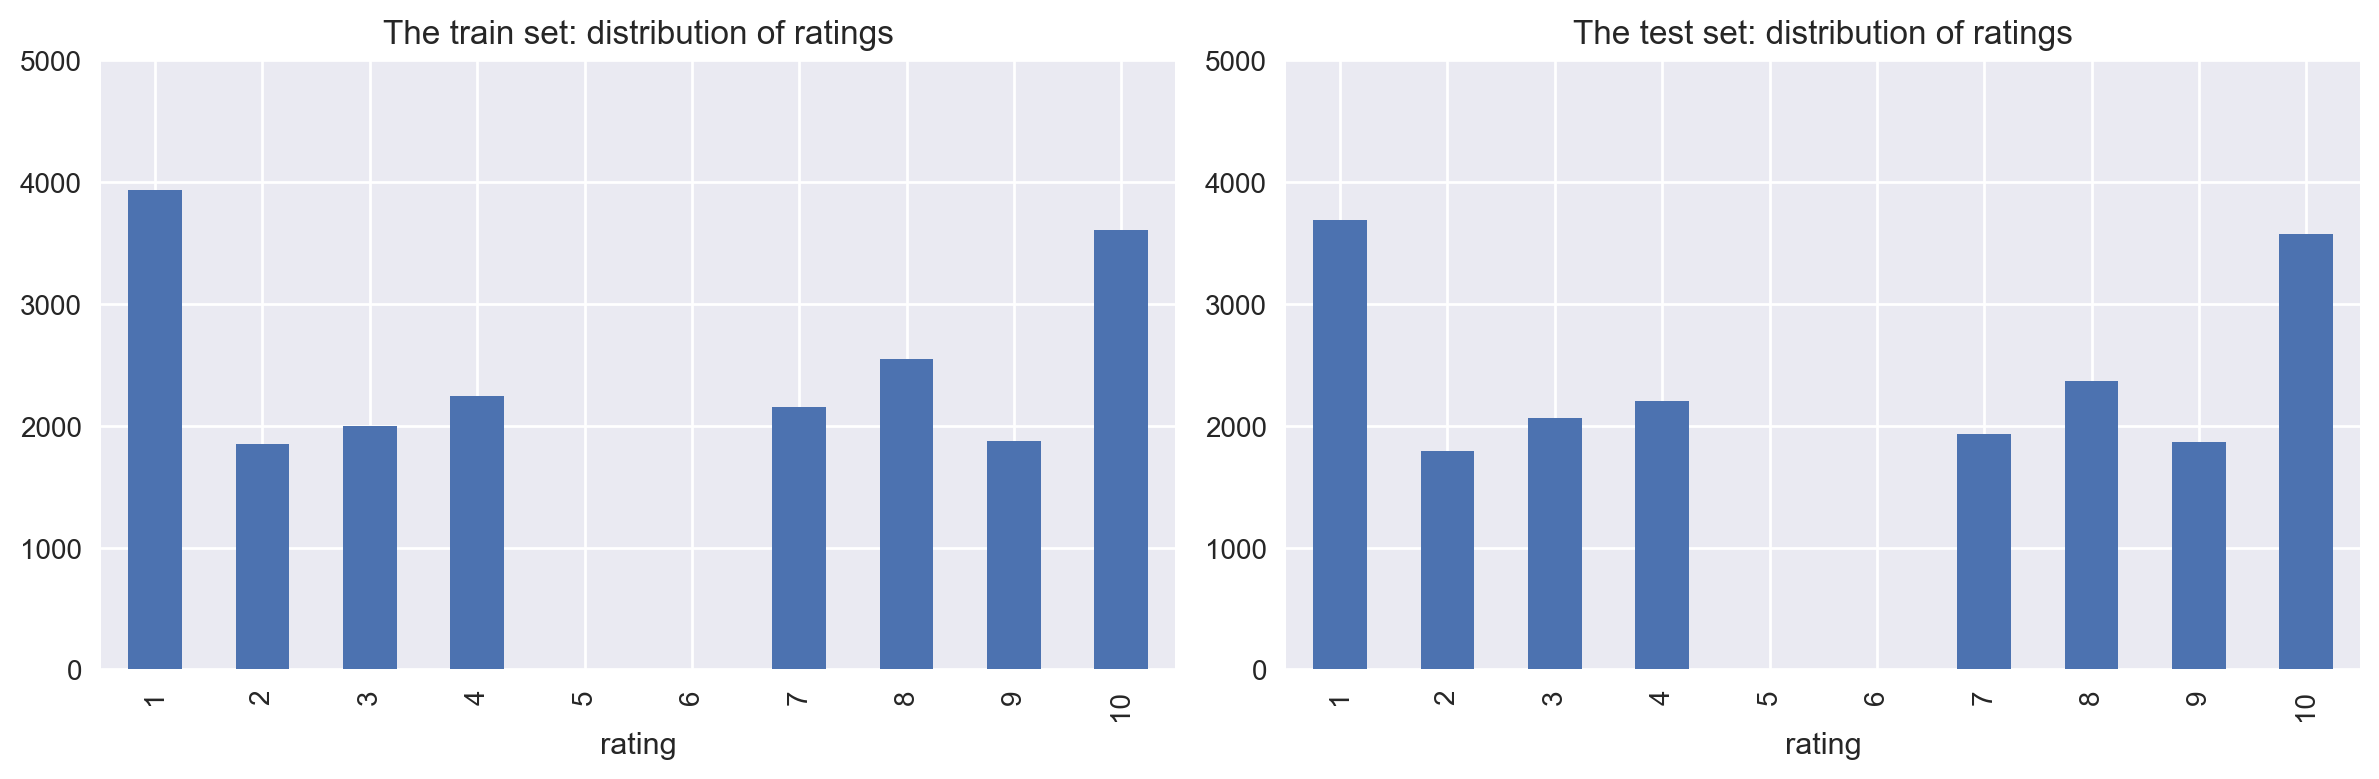

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Great, the distribution of ratings align very nicely between the train and test sets. Lets examine the distribution of negative and positive reviews (our target variable) between the train and test sets.

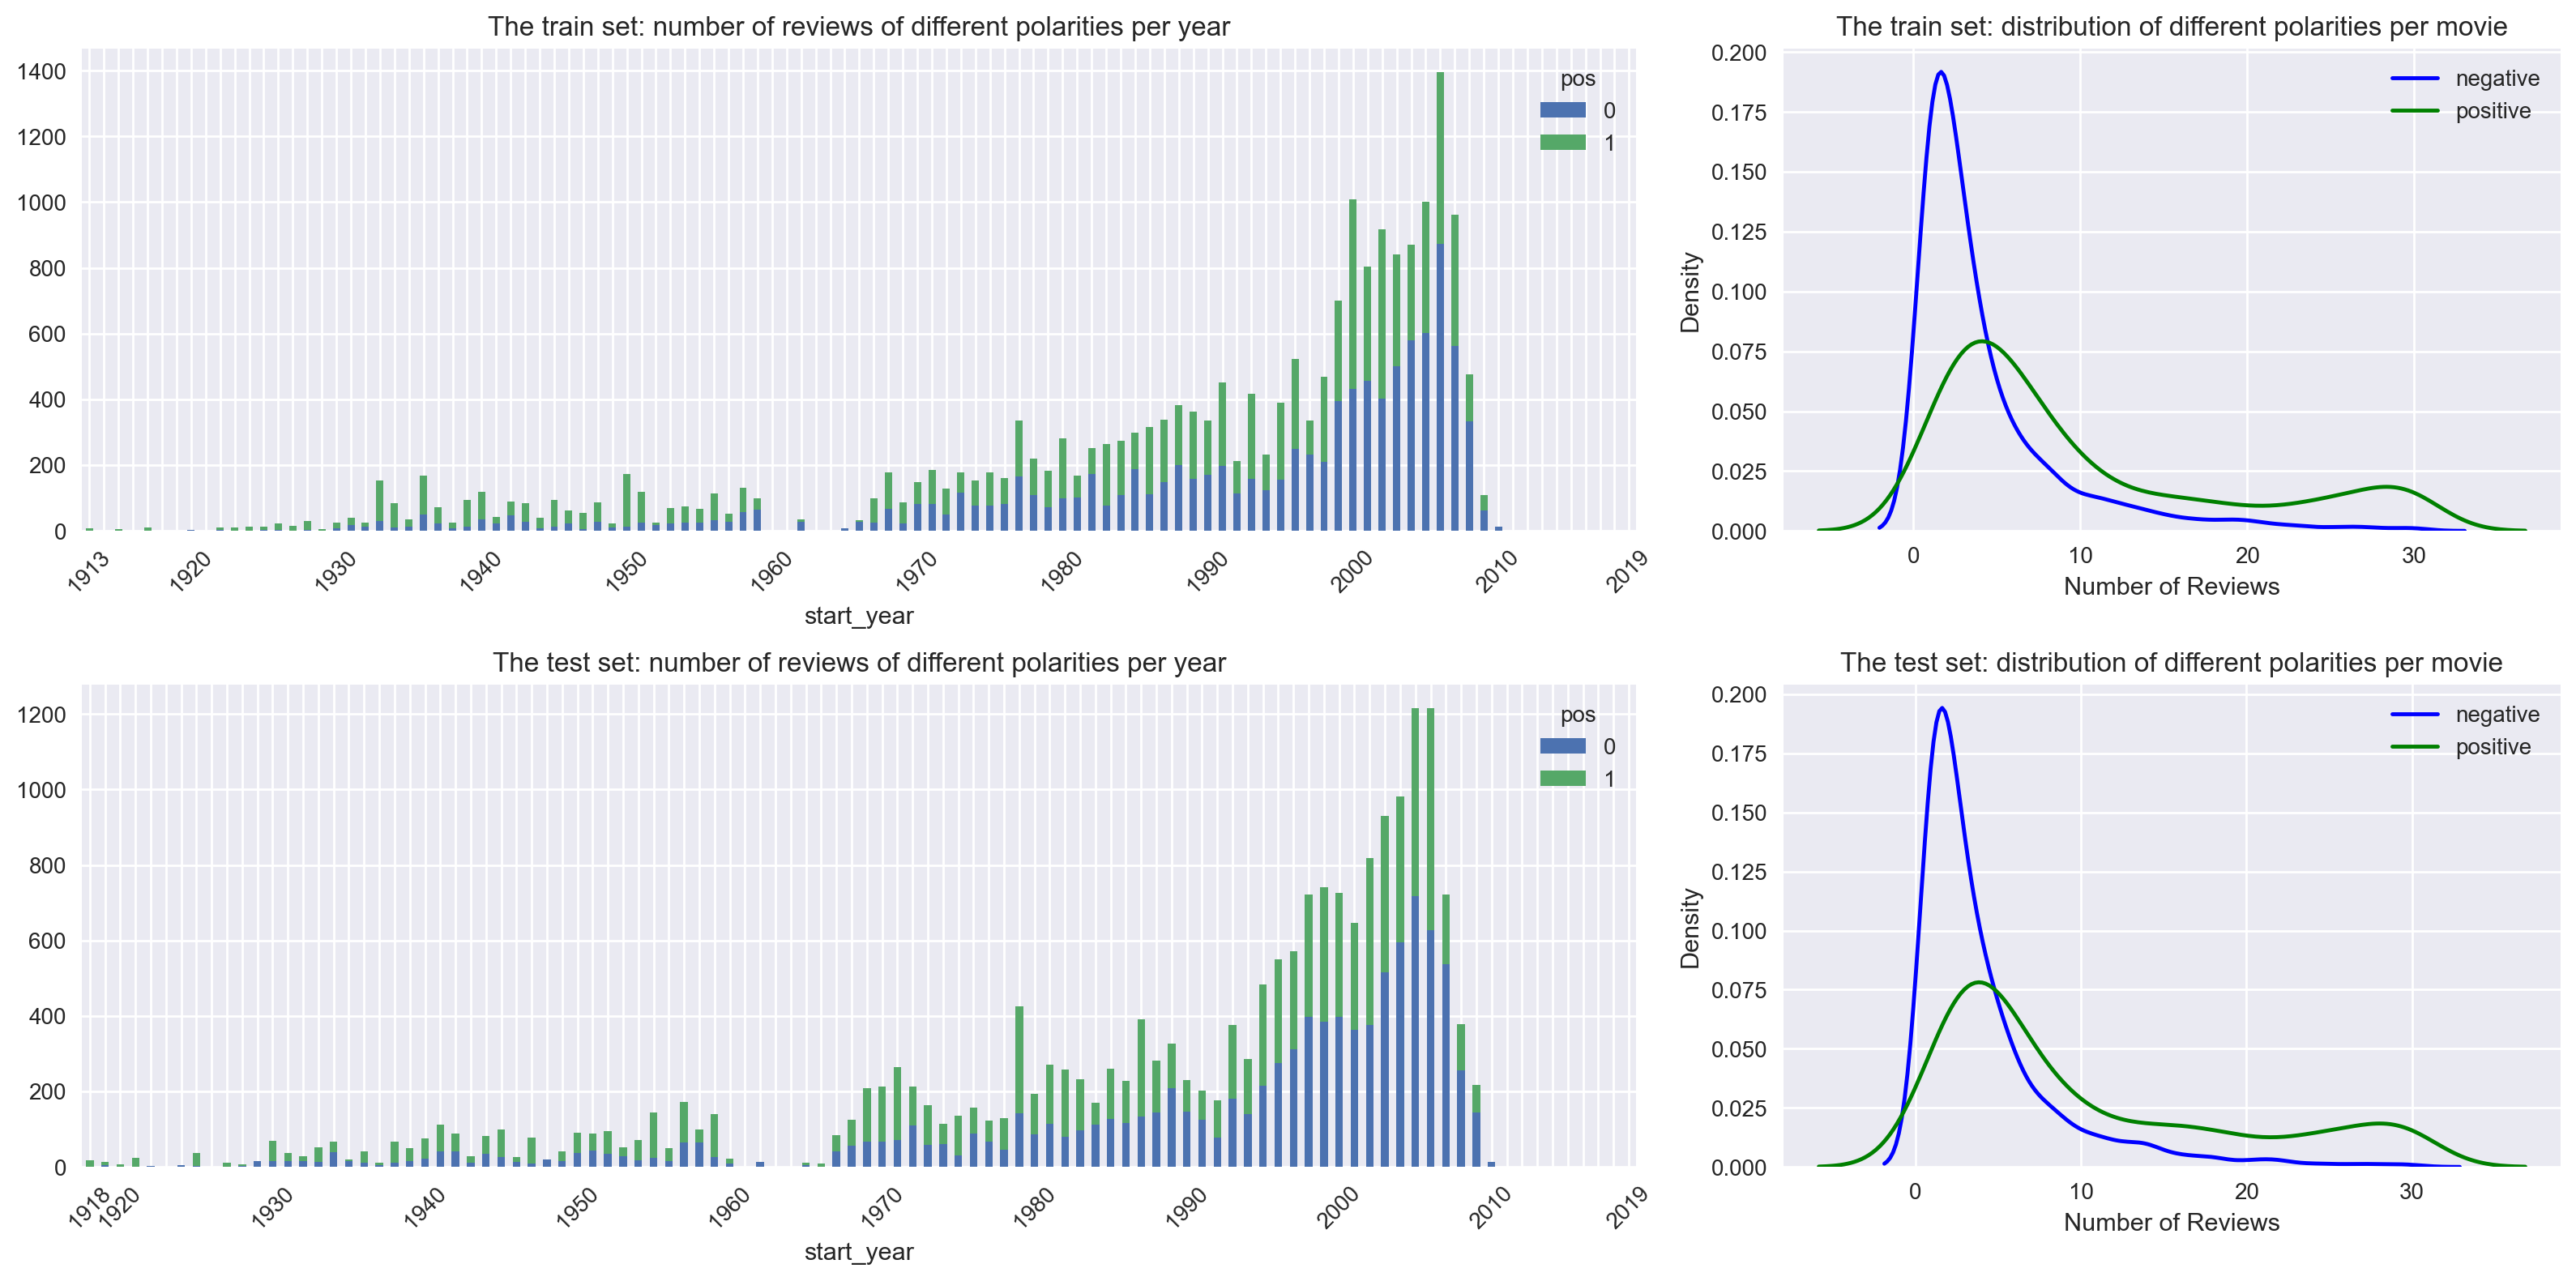

In [14]:
warnings.filterwarnings("ignore", category=UserWarning)

fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0] # top left

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

### Highlight every ten years for visibility ###
# Calculate the range of years
start_year = dft.index.min()
end_year = dft.index.max()

# Select only every ten years
every_ten_years = np.arange(start_year, end_year + 1, 10)

# Set the xticks and xticklabels
ax.set_xticks(np.arange(len(dft.index)))
ax.set_xticklabels(dft.index, rotation=45)  # Rotate labels for better readability
# Highlight every ten years for visibility and include the end year
for label in ax.get_xticklabels():
    year = int(label.get_text())
    if year % 10 != 0 and year != end_year and year != start_year:
        label.set_visible(False)


ax = axs[0][1] # top right

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')
ax.set_ylabel('Density')
ax.set_xlabel('Number of Reviews')

ax = axs[1][0] # bottom left

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

### Highlight every ten years for visibility ###
# Calculate the range of years
start_year = dft.index.min()
end_year = dft.index.max()

# Select only every ten years
every_ten_years = np.arange(start_year, end_year + 1, 10)

# Set the xticks and xticklabels
ax.set_xticks(np.arange(len(dft.index)))
ax.set_xticklabels(dft.index, rotation=45)  # Rotate labels for better readability
# Highlight every ten years for visibility and include the end year
for label in ax.get_xticklabels():
    year = int(label.get_text())
    if year % 10 != 0 and year != end_year and year != start_year:
        label.set_visible(False)

ax = axs[1][1] # bottom right

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')
ax.set_ylabel('Density')
ax.set_xlabel('Number of Reviews')

fig.tight_layout()

warnings.filterwarnings("default", category=UserWarning)

In [15]:
print("Consider the balance of classes where 0 is negative and 1 is positive:")
print(df_reviews['pos'].value_counts())
print()

print("### For the entire dataset ###")
print(f"Negative reviews make up {(1-df_reviews['pos'].mean())*100:.2f}% of the dataset")
print(f"Positive reviews make up {(df_reviews['pos'].mean())*100:.2f}% of the dataset")

print("\n### For the train set ###")
negative_percent = (1 - df_reviews.query('ds_part == "train"')['pos'].mean()) * 100
positive_percent = df_reviews.query('ds_part == "train"')['pos'].mean() * 100
print(f"Negative reviews make up {negative_percent:.2f}% of the train set")
print(f"Positive reviews make up {positive_percent:.2f}% of the train set")

print(f"\n### For the test set ###")
negative_percent = (1 - df_reviews.query('ds_part == "test"')['pos'].mean()) * 100
positive_percent = df_reviews.query('ds_part == "test"')['pos'].mean() * 100
print(f"Negative reviews make up {negative_percent:.2f}% of the test set")
print(f"Positive reviews make up {positive_percent:.2f}% of the test set")

Consider the balance of classes where 0 is negative and 1 is positive:
pos
1    19914
0    19768
Name: count, dtype: int64

### For the entire dataset ###
Negative reviews make up 49.82% of the dataset
Positive reviews make up 50.18% of the dataset

### For the train set ###
Negative reviews make up 49.62% of the train set
Positive reviews make up 50.38% of the train set

### For the test set ###
Negative reviews make up 50.02% of the test set
Positive reviews make up 49.98% of the test set


From the above calculations and visualization, we can see the train and test data sets are well balanced in terms of their share of positive and negative reviews with respect to `start_year` and the number of reviews per movie. Thankfully the team has already provided us with well balanced data. No additional steps need to be taken to balance the sets or target variable.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [42]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return df_eval_stats

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc. Thus, we need a to transform our review text to adhere to that expectation

In [18]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [25]:
def normalize_text(text):
    """
    Normalize the given text by converting it to lowercase, removing punctuation, digits, and special characters,
    and getting rid of extra spaces.
    
    Args:
        text (str): The text to be normalized.
    
    Returns:
        str: The normalized text.
    """
    # Lowercase
    norm_text = text.lower()
    # Remove punctuation digits and special characters
    norm_text = re.sub(r'[^a-z\']', " ", norm_text)
    # Get rid of extra spaces
    norm_text = norm_text.split()
    norm_text = " ".join(norm_text)
    
    # Lemmatize
    doc = nlp(norm_text)
    
    lemas = []
    for token in doc:
        lemas.append(token.lemma_)
        
    norm_text = " ".join(lemas)
    
    # nlp capitalizes pronouns, so we need to lowercase them
    norm_text = norm_text.lower()
    
    return norm_text


# Test the function
print(normalize_text("I'm a test string! 1234 checking the function's functionality."))
    

i be a test string check the function 's functionality


In [22]:
df_reviews['review_norm'] = df_reviews['review'].progress_apply(normalize_text)

  0%|          | 0/39682 [00:00<?, ?it/s]

In [23]:
# Save df_reviews to a file to avoid re-running the normalization function
try:
    df_reviews.to_csv('data/df_reviews_normalized.csv', index=False)
except: # Load the file
    df_reviews = pd.read_csv('data/df_reviews_normalized.csv')

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [28]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print("Train shape:",df_reviews_train.shape)
print("Test shape:",df_reviews_test.shape)

Train shape: (20207, 18)
Test shape: (19475, 18)


In [30]:
# Define the corpus
corpus = df_reviews_train['review_norm']

# Define the stopwords
stopwords = list(nltk_stopwords.words('english'))

# Create the vectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords)

# Fit the vectorizer
vectorizer.fit(corpus)

# Define the features
X_train = vectorizer.transform(corpus)
X_test = vectorizer.transform(df_reviews_test['review_norm'])

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (20207, 54826)
Test shape: (19475, 54826)


## Working with models

### Constant Model

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


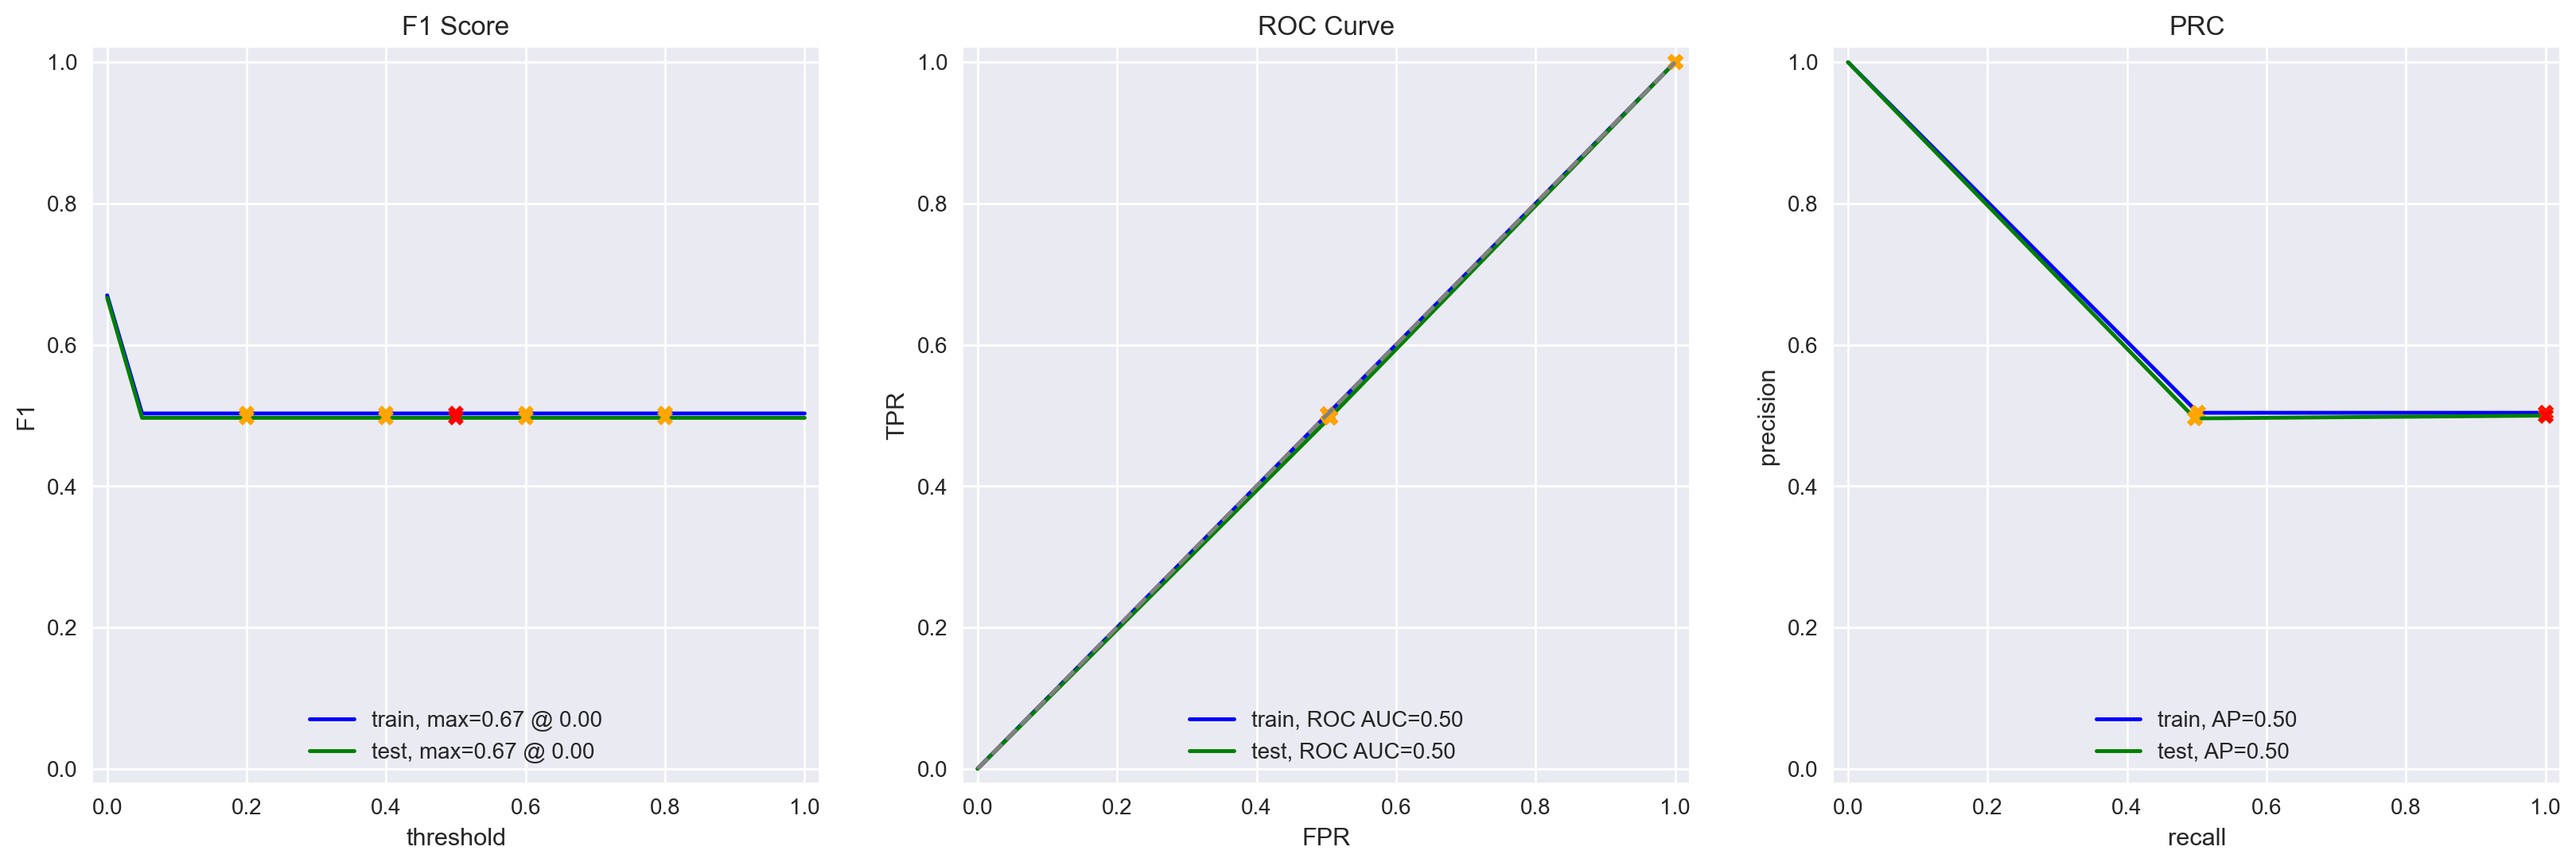

In [43]:
# Create a dummy classifier
model = DummyClassifier(strategy='stratified', random_state=12345)

# Fit the model
model.fit(X_train, train_target)

# Evaluate the model
dummy_results = (model, evaluate_model(model, X_train, train_target, X_test, test_target))


Performance is consistent with what we would expect for random guessing. Basically a 50% chance on each prediction. 

### Linear Regression

          train  test
Accuracy   0.93  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


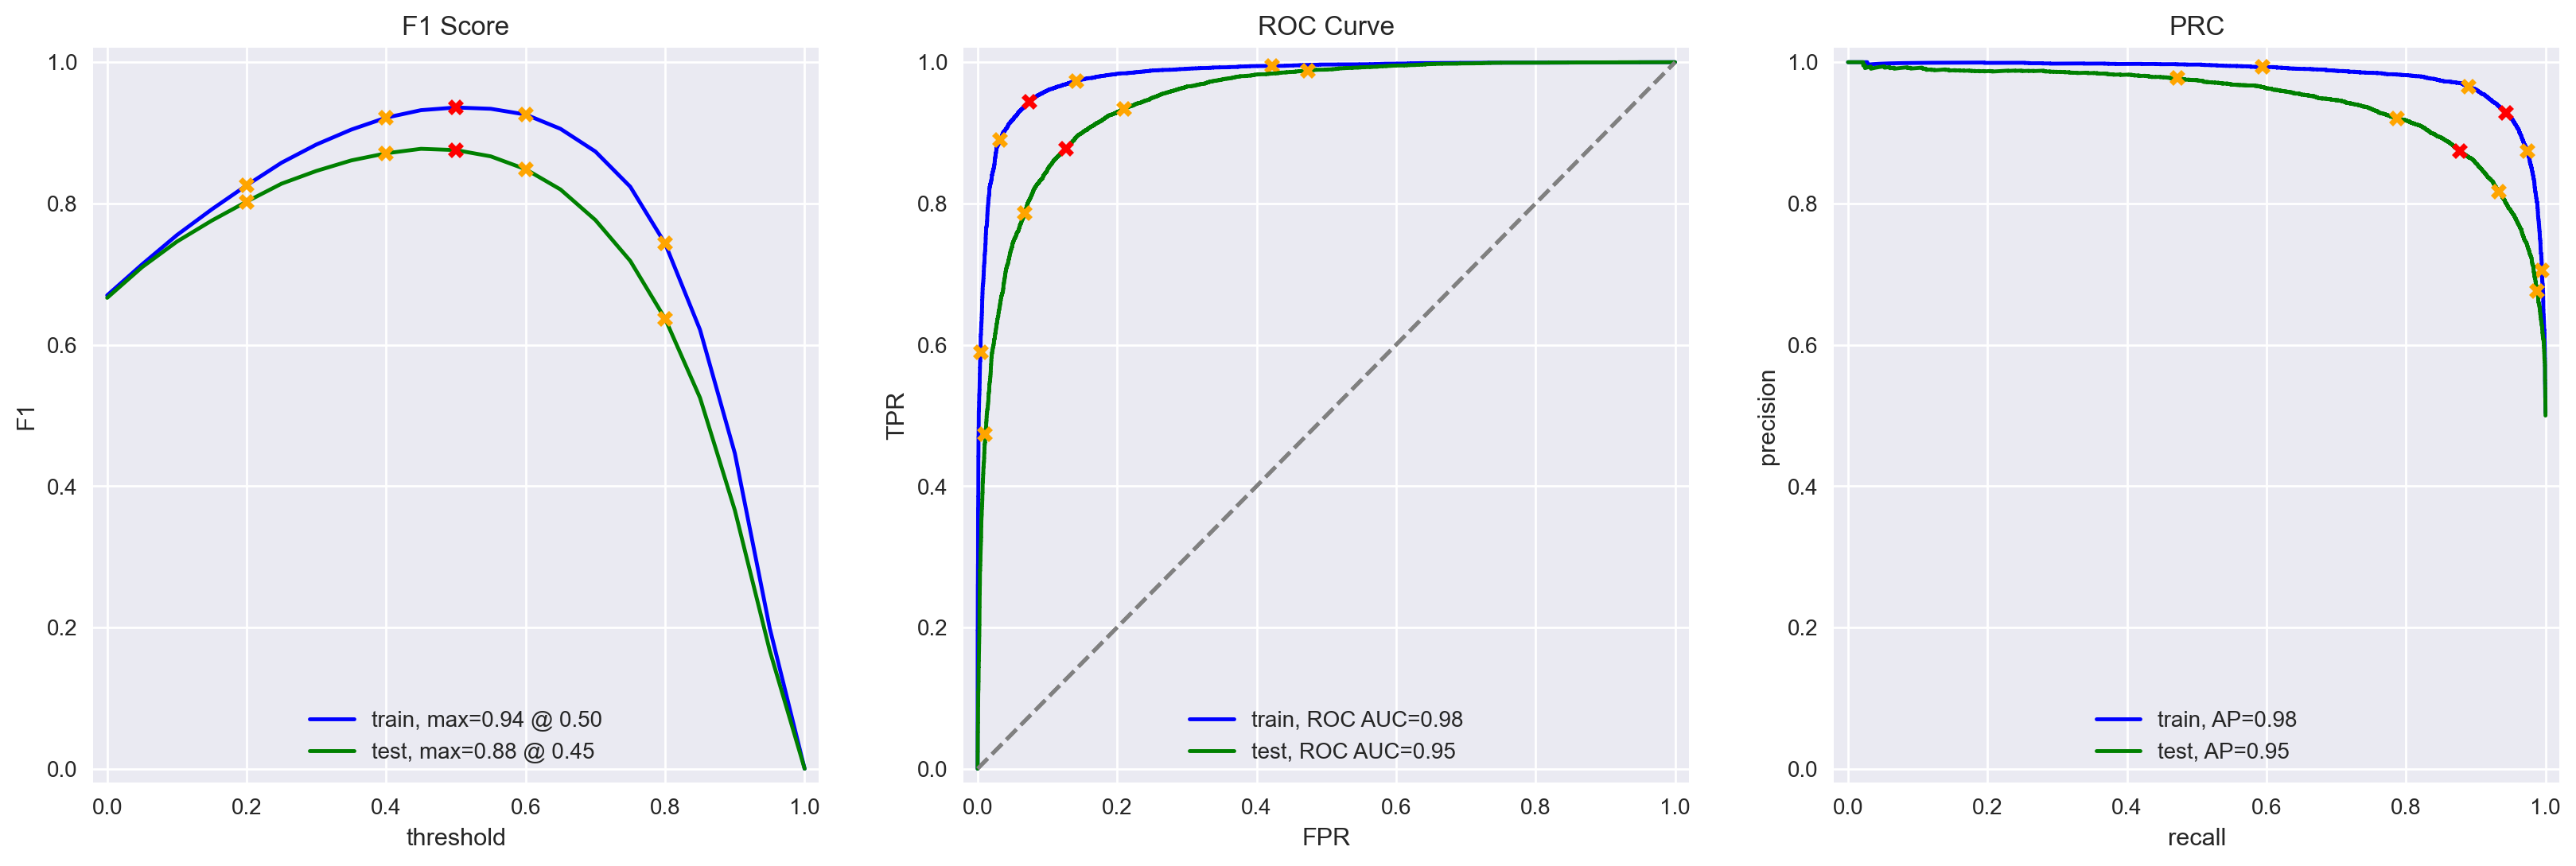

In [52]:
# Define the model
model = LogisticRegression(random_state=12345)

# Fit the model
model.fit(X_train, train_target)

# Evaluate the model
lr_results = (model, evaluate_model(model, X_train, train_target, X_test, test_target))

Our first real model is already performing quite well. It returns an F1 score of .88 on the test set (the successful model threshold is an F1 score of .85). We can also see that the ideal thresholds for the train and tests sets are very near eac other, indicating consistent performance.  

The ROC curve for both the training and test sets is very close to the top left corner, indicating high true positive rates and low false positive rates. This suggests that the model is excellent at distinguishing between positive and negative reviews, with very few incorrect classifications.  

The Precision-Recall curves for both sets remain near the top-right corner, indicating high precision and recall across various thresholds. This means the model consistently makes accurate positive predictions while also capturing most of the actual positive cases, demonstrating robust performance in handling class imbalance.

### Random Forrest

          train  test
Accuracy    1.0  0.81
F1          1.0  0.81
APS         1.0  0.87
ROC AUC     1.0  0.89


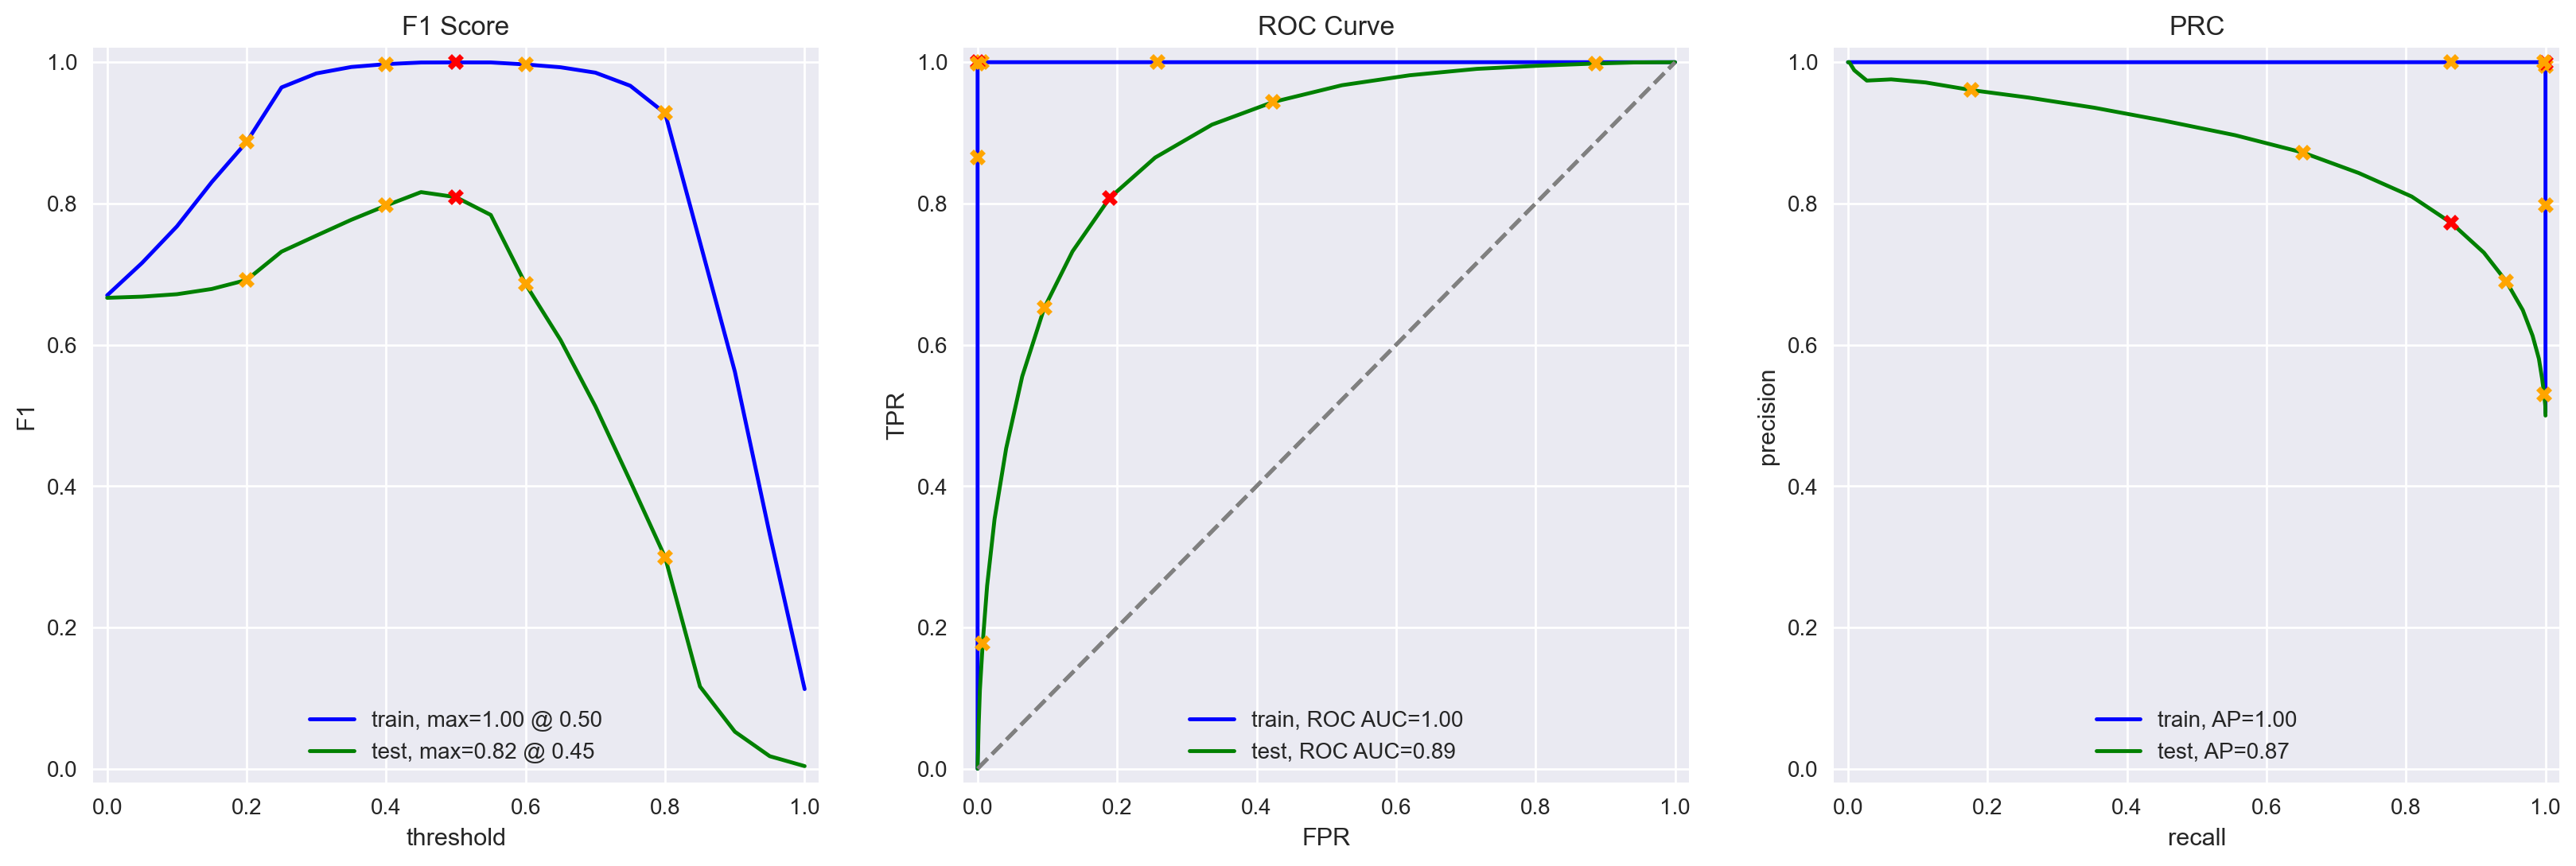

In [51]:
# Define the model
model = RandomForestClassifier(n_estimators=25, random_state=12345)

# Fit the model
model.fit(X_train, train_target)

# Evaluate the model
rf_results = (model, evaluate_model(model, X_train, train_target, X_test, test_target))

The Random Forest model demonstrates excellent performance on the training data, achieving perfect scores across F1, ROC AUC, and APS metrics, which indicates it is overfitting to the training set. In contrast, its performance on the test data is notably lower, with an F1 score of 0.82, a ROC AUC of 0.89, and an APS of 0.87. 

This disparity between the training and test set performances suggests the model fails to generalize well to unseen data. Furthermore, compared to the Linear Regression model, the Random Forest model's lower ROC AUC and APS scores on the test set confirm that it is less effective at distinguishing between positive and negative reviews and maintaining a high precision and recall balance.

### LGBMClassifier

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


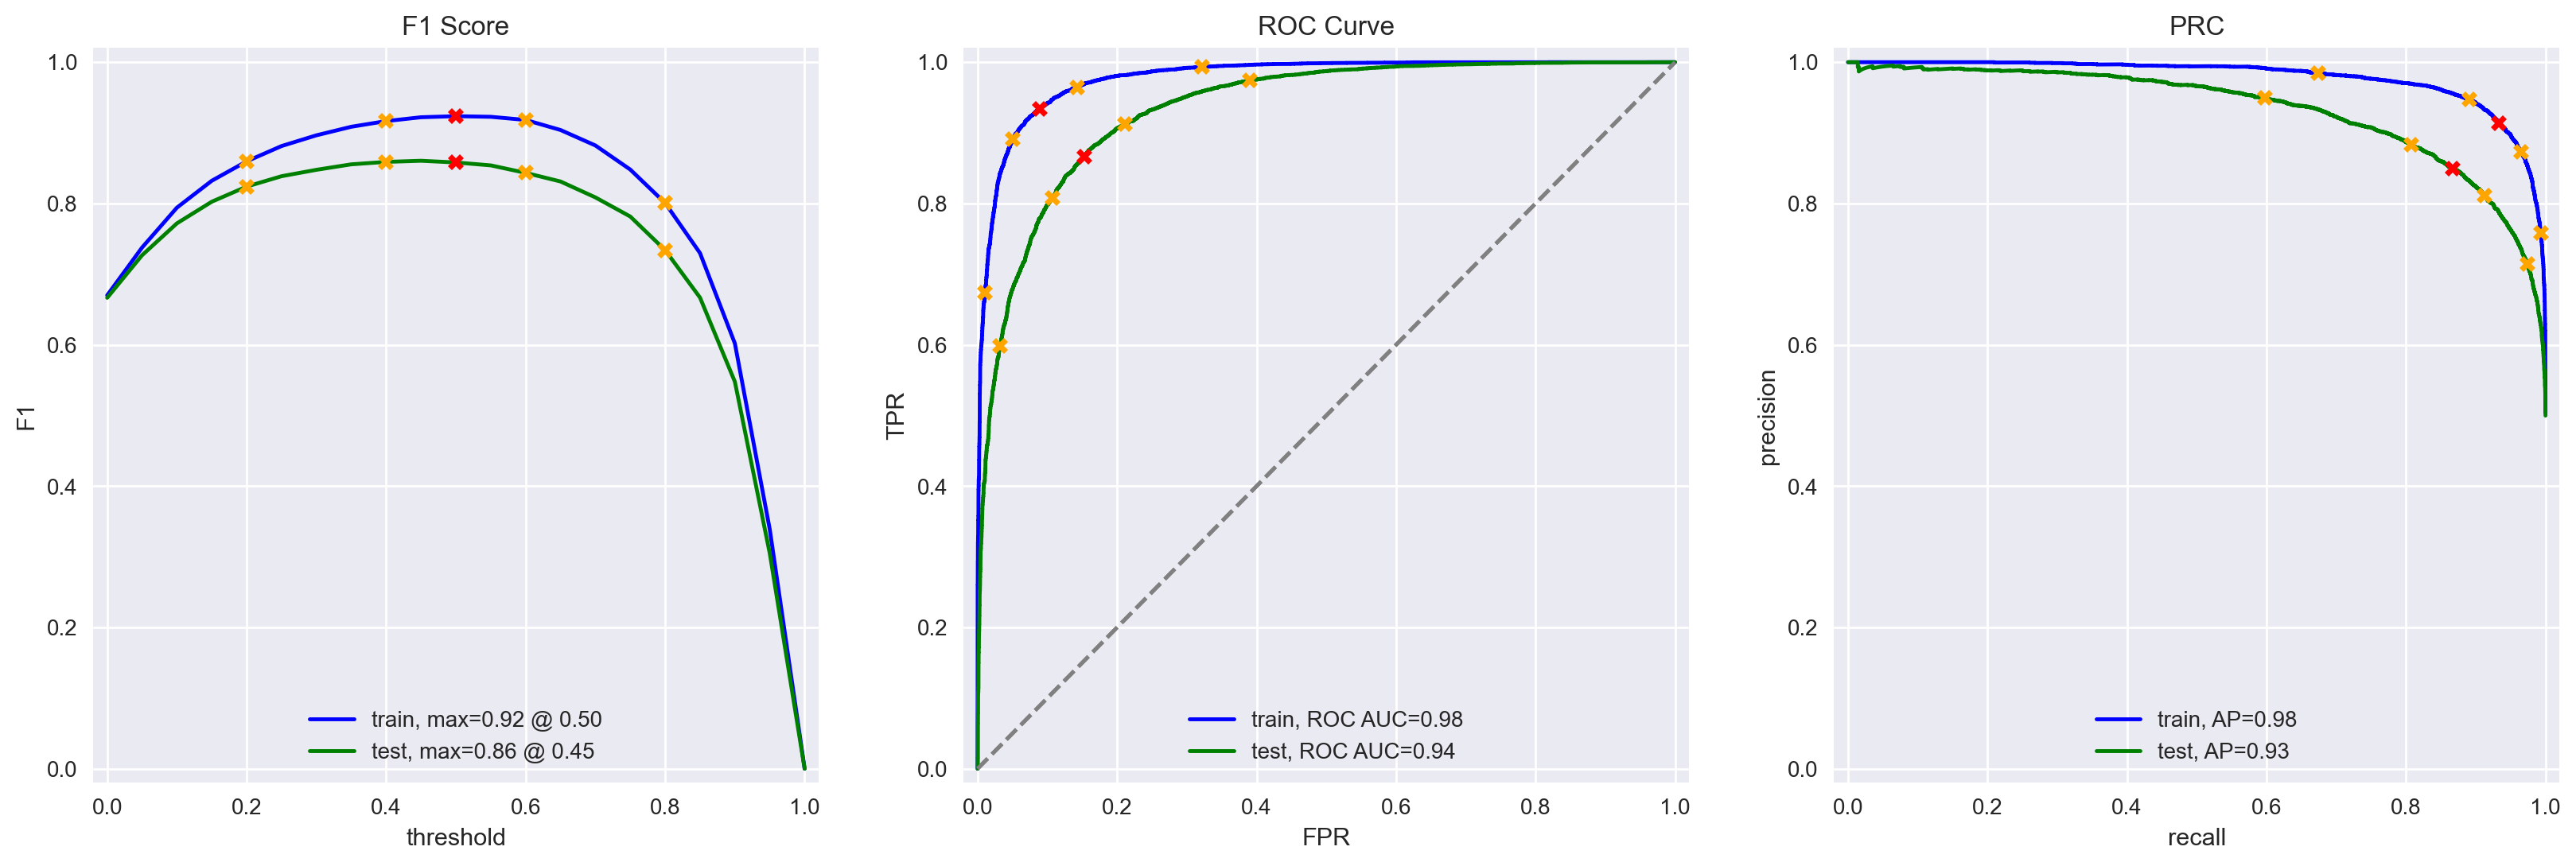

In [55]:
# Define the model
model = LGBMClassifier(random_state=12345)

# Fit the model
model.fit(X_train, train_target)

# Evaluate the model
lgbm_results = (model, evaluate_model(model, X_train, train_target, X_test, test_target))

The LightGBM model performs well enough to meet the threshold of our task, but still does not outperform the Linear Regression model.

## My Reviews

In [61]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].progress_apply(normalize_text)
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1]

my_reviews

  0%|          | 0/8 [00:00<?, ?it/s]

,review,review_norm,pos
0,"I did not simply like it, not my kind of movie.",i do not simply like it not my kind of movie,0
1,"Well, I was bored and felt asleep in the middl...",well i be bored and feel asleep in the middle ...,0
2,I was really fascinated with the movie,i be really fascinated with the movie,1
3,Even the actors looked really old and disinter...,even the actor look really old and disinterest...,0
4,I didn't expect the reboot to be so good! Writ...,i do not expect the reboot to be so good write...,1
5,"The movie had its upsides and downsides, but I...",the movie have its upside and downside but i f...,1
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,0
7,Launching on Netflix was a brave move & I real...,launch on netflix be a brave move i really app...,1


### Constant Model

0.00: I did not simply like it, not my kind of movie.
1.00: Well, I was bored and felt asleep in the middle of the movie.
1.00: I was really fascinated with the movie
1.00: Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.
0.00: I didn't expect the reboot to be so good! Writers really cared about the source material
0.00: The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.
0.00: What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!
0.00: Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.

          train  test
Accuracy    0.5  0.38
F1          0.5  0.29
APS         0.5  0.46
ROC AUC     0.5  0.38


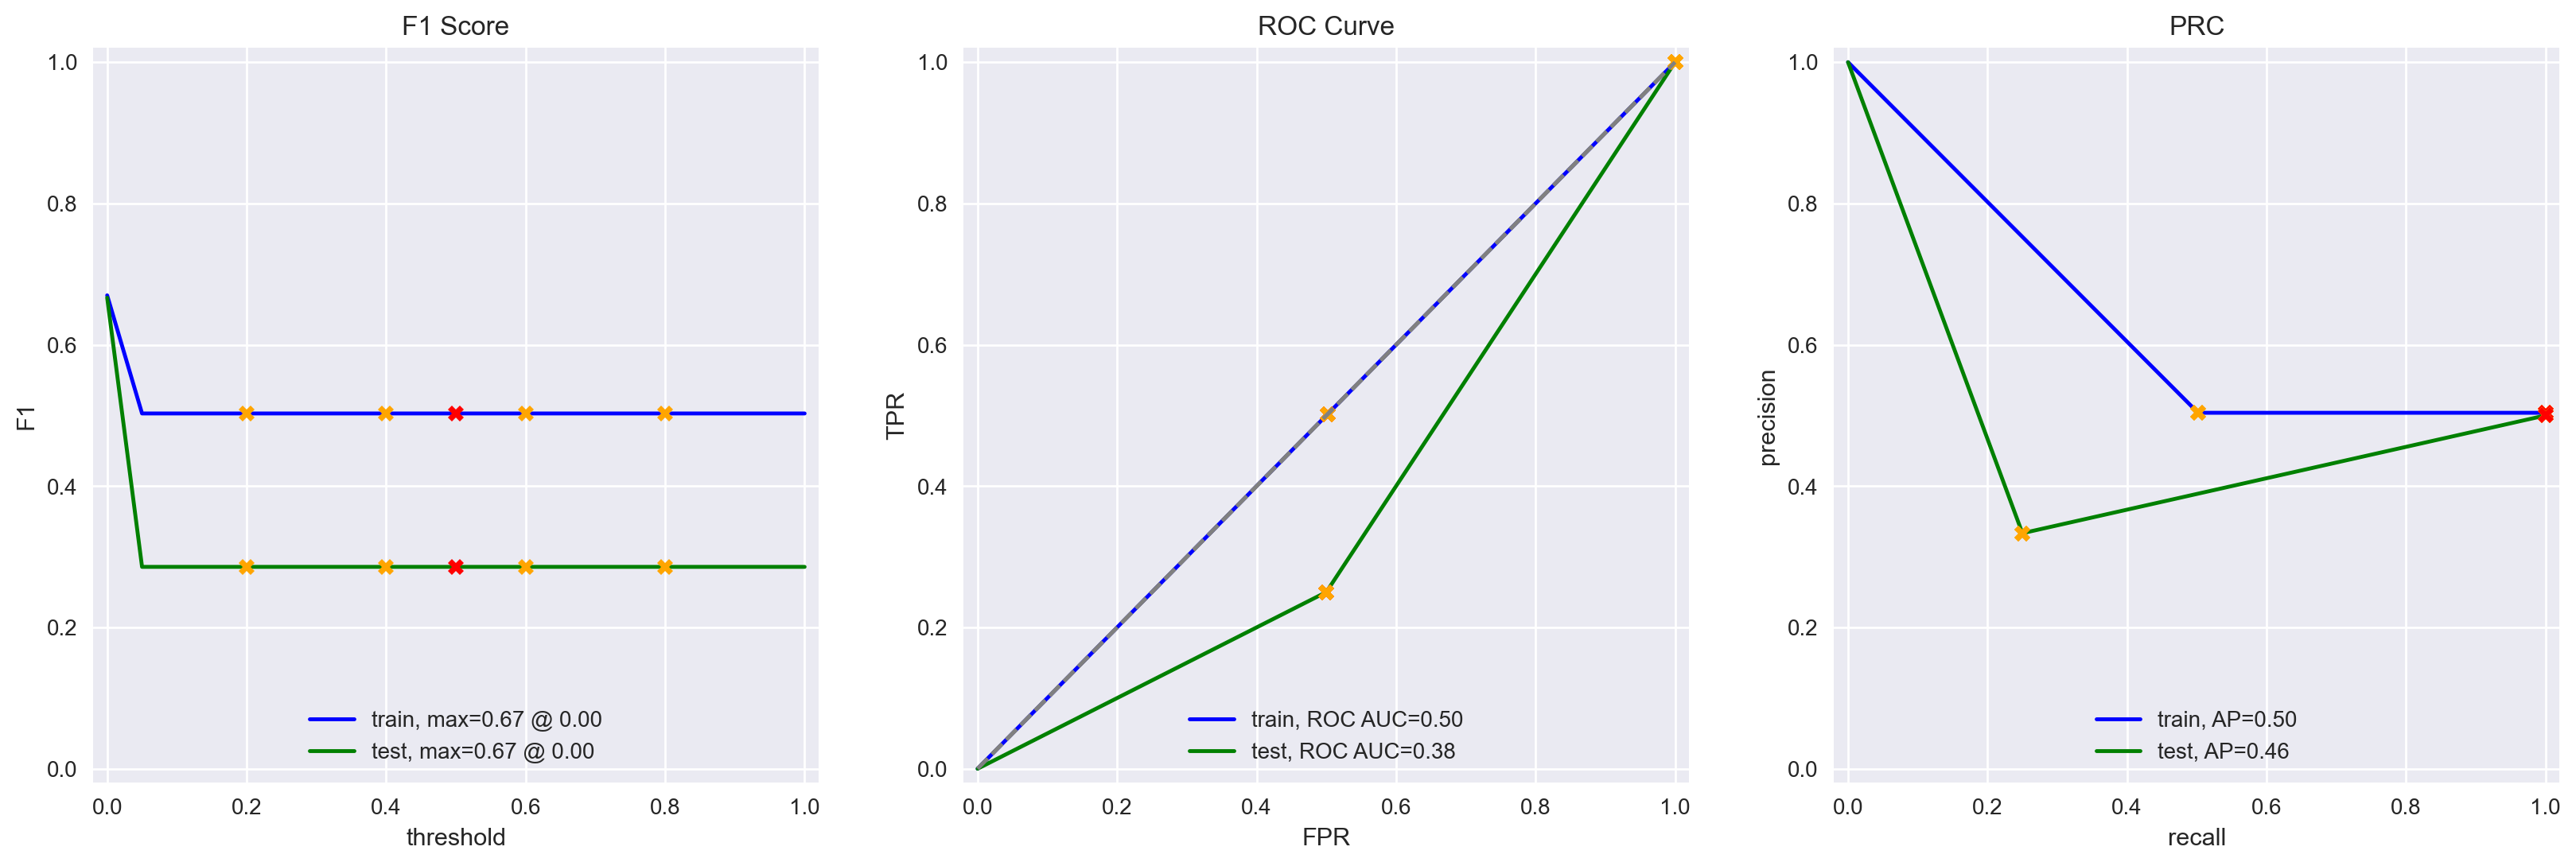

In [87]:
texts = my_reviews['review_norm']
X_test = vectorizer.transform(texts)

# Define the model
model = dummy_results[0]

# Get probabilities
my_reviews_pred_prob = model.predict_proba(X_test)[:, 1]

for i, review in enumerate(texts.str.slice(0,100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {my_reviews.iloc[i]["review"]}')
    
print()

# Evaluate the model
dummy_my_reviews_results = evaluate_model(model, X_train, train_target, X_test, my_reviews['pos'])

### Linear Regression

0.20: I did not simply like it, not my kind of movie.
0.17: Well, I was bored and felt asleep in the middle of the movie.
0.48: I was really fascinated with the movie
0.13: Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.
0.26: I didn't expect the reboot to be so good! Writers really cared about the source material
0.51: The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.
0.04: What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!
0.77: Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.

          train  test
Accuracy   0.93  0.75
F1         0.94  0.67
APS        0.98  1.00
ROC AUC    0.98  1.00


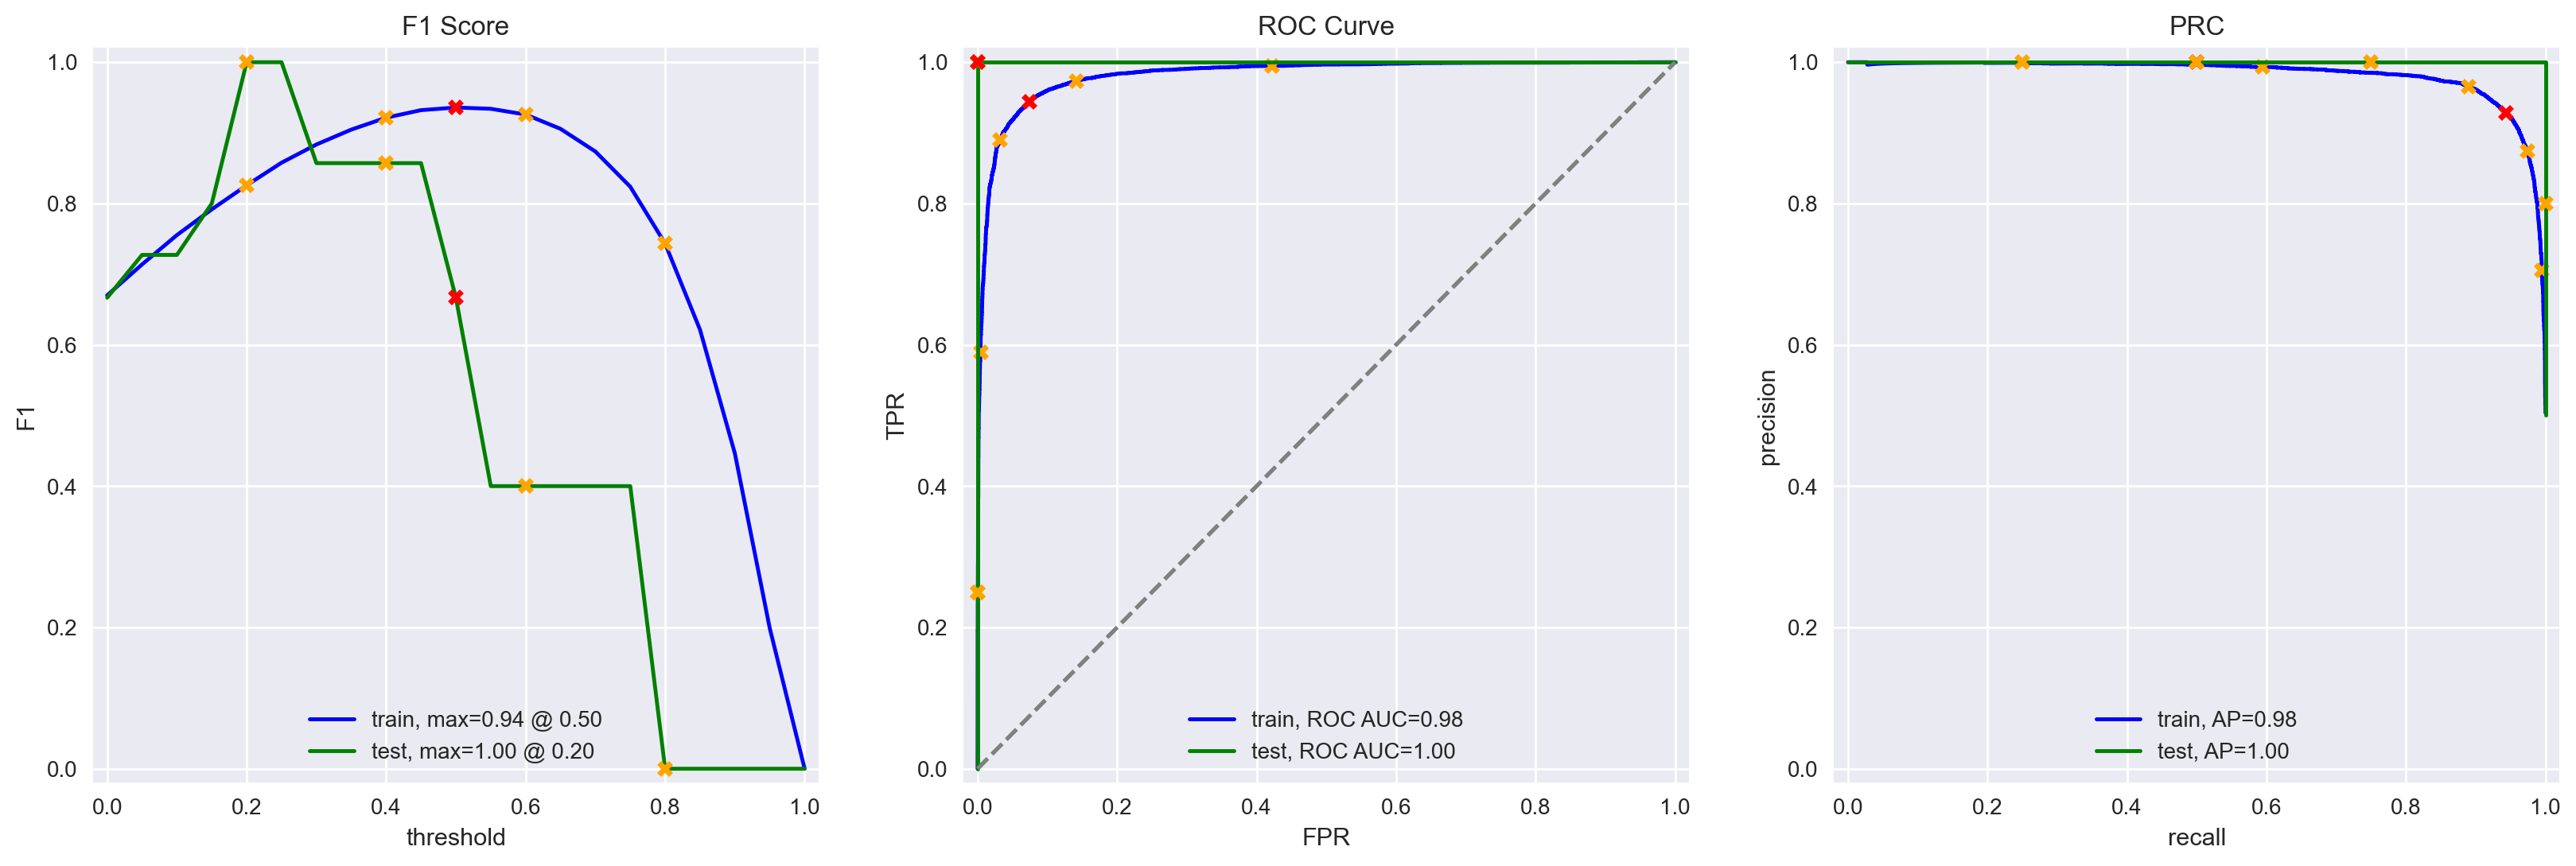

In [88]:
# Define the model
model = lr_results[0]

my_reviews_pred_prob = model.predict_proba(X_test)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {my_reviews.iloc[i]["review"]}')

print()
# Evaluate the model
lr_my_reviews_results = evaluate_model(model, X_train, train_target, vectorizer.transform(my_reviews['review_norm']), my_reviews['pos'])

### Random Forrest

0.68:  I did not simply like it, not my kind of movie.
0.80:  Well, I was bored and felt asleep in the middle of the movie.
0.80:  I was really fascinated with the movie
0.40:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.
0.52:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.64:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.
0.28:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!
0.84:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.

          train  test
Accuracy    1.0  0.75
F1          1.0  0.80
APS         1.0  0.73
ROC AUC     1.0  0.72


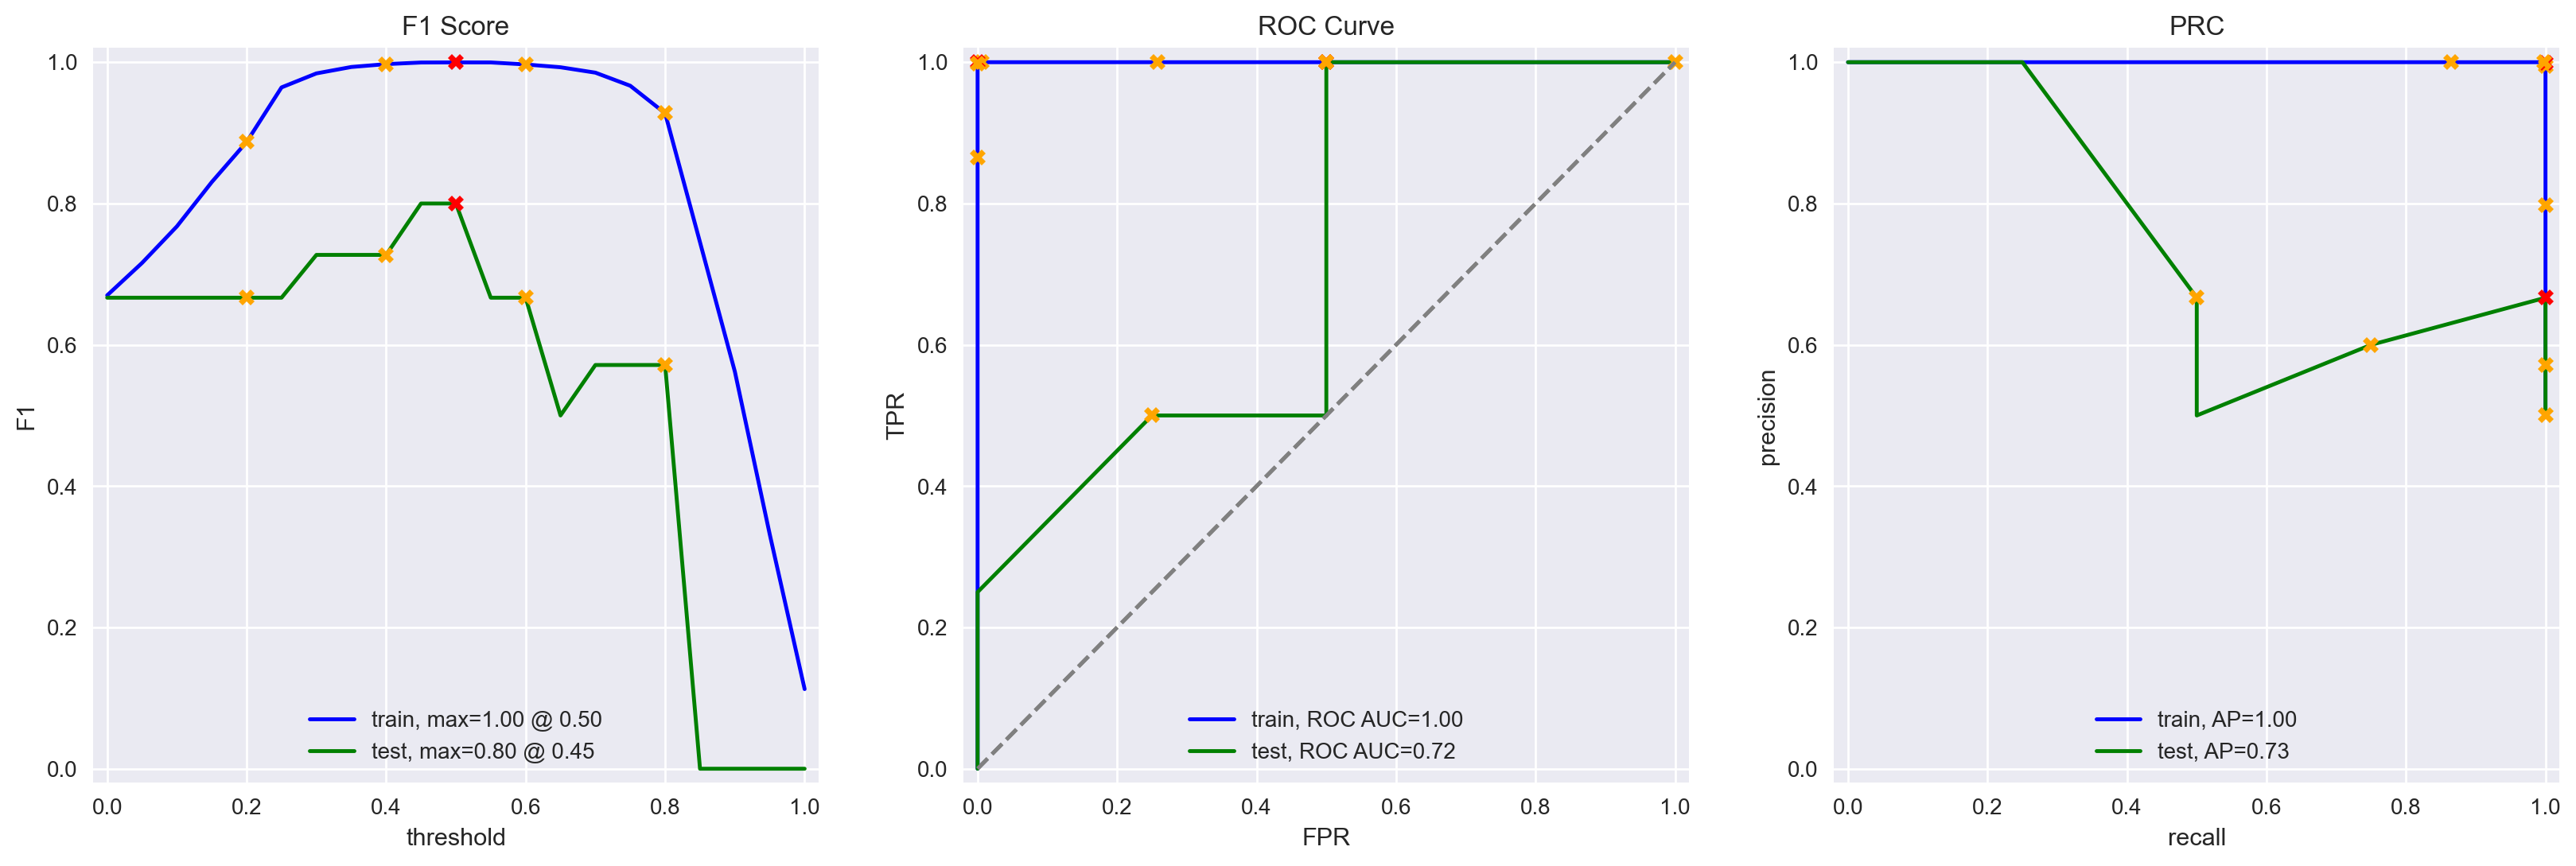

In [114]:
model = rf_results[0]

my_reviews_pred_prob = model.predict_proba(X_test)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {my_reviews.iloc[i]["review"]}')
    
print()
# Evaluate the model
rf_my_reviews_results = evaluate_model(model, X_train, train_target, X_test, my_reviews['pos'])

### LightGBM

0.51:  I did not simply like it, not my kind of movie.
0.53:  Well, I was bored and felt asleep in the middle of the movie.
0.57:  I was really fascinated with the movie
0.38:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.
0.65:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.66:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.
0.18:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!
0.71:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.

          train  test
Accuracy   0.92  0.75
F1         0.92  0.80
APS        0.98  1.00
ROC AUC    0.98  1.00


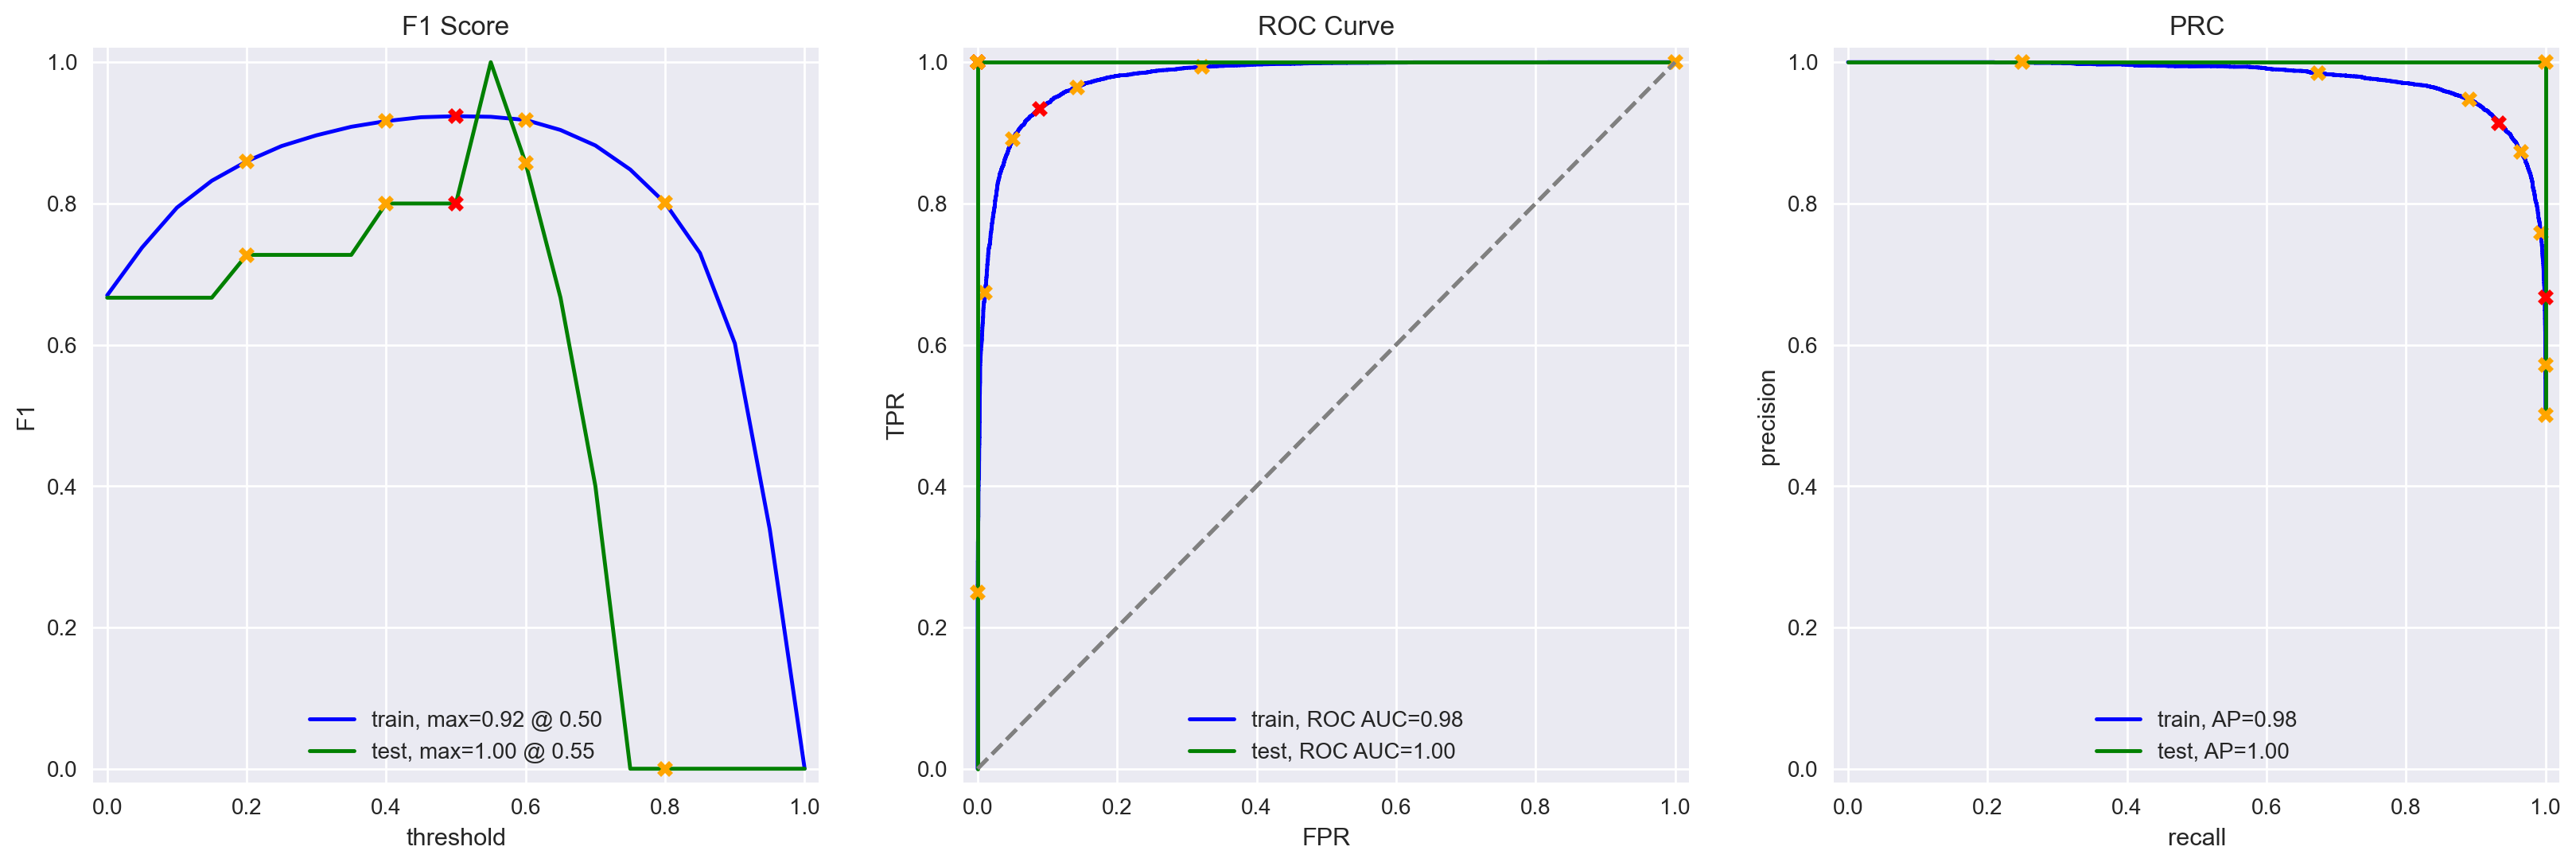

In [90]:
# Define the model
model = lgbm_results[0]

my_reviews_pred_prob = model.predict_proba(X_test)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {my_reviews.iloc[i]["review"]}')
    
print()
# Evaluate the model
lgbm_my_reviews_results = evaluate_model(model, X_train, train_target, X_test, my_reviews['pos'])

In [69]:
print("The average length of reviews in the train set is", df_reviews_train['review'].str.len().mean())
print("The average length of reviews in the test set is", df_reviews_test['review'].str.len().mean())
print("The average length of reviews in my reviews is", my_reviews['review'].str.len().mean())

The average length of reviews in the train set is 1318.236650665611
The average length of reviews in the test set is 1288.310192554557
The average length of reviews in my reviews is 92.75


## Conclusions

In [159]:
# Combine the results into a single DataFrame, only take the test results
testing_results = pd.concat([dummy_results[1]['test'], lr_results[1]['test'], rf_results[1]['test'], lgbm_results[1]['test']], keys=['Dummy', 'Logistic Regression', 'Random Forest', 'LightGBM'], axis=1).T


# Combine my reviews results into a single DataFrame, only take the test results

my_reviews_results = pd.concat([dummy_my_reviews_results['test'], lr_my_reviews_results['test'], rf_my_reviews_results['test'], lgbm_my_reviews_results['test']], keys=['Dummy', 'Logistic Regression', 'Random Forest', 'LightGBM'], axis=1).T

# Combine these results into a single DataFrame with Keys as the index
combined_results = pd.merge(testing_results, my_reviews_results, left_index=True, right_index=True, suffixes=('_data', '_my_reviews'))


# Reorder the columns
ordered_columns = [
    'Accuracy_data', 'Accuracy_my_reviews',
    'F1_data', 'F1_my_reviews',
    'APS_data', 'APS_my_reviews',
    'ROC AUC_data', 'ROC AUC_my_reviews'
]

combined_results = combined_results[ordered_columns]
display(combined_results)

,Accuracy_data,Accuracy_my_reviews,F1_data,F1_my_reviews,APS_data,APS_my_reviews,ROC AUC_data,ROC AUC_my_reviews
Dummy,0.50,0.38,0.50,0.29,0.50,0.46,0.50,0.38
Logistic Regression,0.88,0.75,0.88,0.67,0.95,1.00,0.95,1.00
Random Forest,0.81,0.75,0.81,0.80,0.87,0.73,0.89,0.72
LightGBM,0.86,0.75,0.86,0.80,0.93,1.00,0.94,1.00


# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions